In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from os.path import join

import pipeline.features
import pipeline.models

base_path = '../../own_data/191104_depr_splits_features/'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


# Проверка признаков на отложенной выборке

In [4]:
dir_ = '60s_1_0_60'
df_1 = pipeline.features.get_merged_df(join(base_path, dir_), feature_methods)

In [5]:
model = pipeline.models.LRScaled()

In [10]:
features = [col for col in df_1.columns if col not in ['fn', 'target']]
features_no_val, score_no_val, hist = pipeline.models.select_features(df_1, features, model)

Feature selection. Step 1


coh_beta_fp1_fz


/home/max/anaconda3/envs/neuroml/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


0.5251010101010101 0.5438202247191011
coh_alpha_fp1_fz
0.5665909090909091 0.5691011235955057
coh_beta_f3_f4
0.7223989898989899 0.6567415730337078
coh_beta_fp2_fz
0.7131565656565656 0.6617977528089889
bands_gamma_fz
0.7963636363636365 0.747752808988764
coh_beta_o1_t5
0.8032828282828282 0.7320224719101123
coh_beta_f7_fz
0.8210858585858585 0.7668539325842697
coh_alpha_f3_f4
0.8262373737373737 0.7589887640449436
env_alpha_c4_o2
0.8151010101010101 0.7595505617977527
coh_alpha_t4_f8
0.8395959595959596 0.7556179775280898
coh_alpha_c4_p3
0.8283585858585859 0.7421348314606742
bands_gamma_p4
0.8502525252525253 0.7550561797752808
coh_beta_o1_o2
0.8432323232323234 0.7556179775280898
coh_alpha_fp2_fz
0.8500757575757577 0.7617977528089886
coh_alpha_f7_fz
0.8454545454545455 0.757303370786517
coh_beta_t4_f8
0.8676515151515151 0.7775280898876404
coh_beta_o2_fz
0.8596212121212121 0.7646067415730335
env_alpha_t6_fz
0.9308585858585857 0.8494382022471909
coh_beta_c3_pz
0.955707070707071 0.8713483146067416


0.967550505050505 0.908426966292135
bands_theta_t6
0.9684595959595962 0.9061797752808991
bands_beta_f7
0.9688383838383837 0.9140449438202248
coh_alpha_f4_p3
0.9700757575757575 0.9269662921348314
env_alpha_c3_t5
0.9677777777777777 0.9202247191011235
bands_alpha_f3
0.9678030303030303 0.9196629213483145
coh_alpha_f8_p4
0.9678030303030305 0.9112359550561798
env_alpha_p4_p3
0.9593434343434343 0.9095505617977528
env_alpha_o2_pz
0.9682828282828281 0.9286516853932584
env_beta_o1_t5
0.9671717171717173 0.9168539325842696
bands_theta_p4
0.9650505050505052 0.9067415730337081
coh_alpha_t5_fp1
0.9725505050505052 0.9241573033707866
env_alpha_t6_pz
0.9632828282828282 0.9207865168539326
coh_beta_fp2_pz
0.963409090909091 0.8983146067415732
coh_beta_f8_pz
0.9654040404040403 0.9140449438202248
env_beta_c4_pz
0.9668939393939391 0.907303370786517
env_alpha_c3_fp1
0.9697222222222223 0.9117977528089888
coh_beta_t5_fz
0.9641666666666666 0.9067415730337078
env_alpha_t3_f4
0.9663131313131315 0.9106741573033709
e

0.9658585858585857 0.9095505617977528
bands_theta_t5
0.9685101010101009 0.9106741573033709
coh_alpha_p4_p3
0.9651010101010101 0.902247191011236
env_beta_o2_t5
0.9661616161616161 0.9022471910112358
coh_beta_c4_p3
0.9693181818181819 0.9123595505617977
env_beta_t3_fp1
0.9652272727272727 0.9140449438202248
bands_beta_o2
0.9693434343434342 0.9146067415730338
coh_alpha_p4_pz
0.9638636363636364 0.9191011235955056
env_alpha_t6_c3
0.9615404040404041 0.911797752808989
coh_beta_f3_fz
0.9691414141414143 0.9140449438202248
env_beta_f7_t5
0.9658080808080806 0.9117977528089888
env_beta_t6_fp1
0.9653030303030302 0.9140449438202248
env_alpha_t4_fp2
0.96770202020202 0.9067415730337078
coh_beta_o1_p4
0.9664393939393939 0.9101123595505619
coh_alpha_f8_o2
0.9686868686868687 0.9123595505617977
coh_alpha_t4_t5
0.9674242424242424 0.9067415730337081
coh_alpha_c3_pz
0.9667171717171718 0.9174157303370787
env_alpha_f7_f3
0.9682070707070707 0.9106741573033709
bands_alpha_fp1
0.9678535353535354 0.9179775280898876
b

0.9683080808080808 0.9151685393258427
coh_beta_o1_fp1
0.9626515151515151 0.9056179775280899
coh_beta_p4_f3
0.9675252525252525 0.9084269662921349
env_alpha_t3_pz
0.9627777777777776 0.9168539325842697
coh_alpha_fp2_pz
0.9671717171717169 0.9129213483146067
coh_beta_c3_fz
0.9658838383838383 0.907303370786517
coh_beta_f8_fz
0.9678030303030305 0.9168539325842697
coh_beta_t5_pz
0.9669444444444444 0.9123595505617977
env_beta_f7_p3
0.9670707070707071 0.912359550561798
env_alpha_o2_c3
0.9618939393939394 0.9089887640449439
env_alpha_c4_c3
0.9650000000000002 0.9089887640449439
env_alpha_c4_f7
0.9618181818181817 0.9011235955056179
coh_alpha_f3_pz
0.9674999999999997 0.9129213483146067
env_alpha_t3_fp2
0.9649747474747473 0.9050561797752812
env_beta_t4_o1
0.9657323232323234 0.9146067415730338
env_alpha_f8_c4
0.9683333333333334 0.908988764044944
env_beta_f7_fp2
0.9651767676767677 0.9230337078651687
coh_alpha_o1_fp2
0.9667424242424243 0.9168539325842696
coh_beta_t6_f3
0.9656313131313133 0.90561797752808

0.965580808080808 0.9067415730337081
coh_alpha_f7_f4
0.9694444444444443 0.9117977528089888
coh_beta_t4_c3
0.9673484848484849 0.9117977528089888
bands_theta_f8
0.9619444444444445 0.912359550561798
coh_beta_o1_c4
0.9679040404040403 0.9089887640449439
coh_alpha_f4_fp2
0.9710353535353538 0.9202247191011235
coh_beta_f8_p4
0.9686363636363637 0.9117977528089887
coh_beta_t6_pz
0.9659090909090906 0.9106741573033709
coh_beta_t3_pz
0.9670707070707071 0.9123595505617977
coh_alpha_t3_f7
0.9673989898989899 0.9106741573033709
coh_alpha_f8_fz
0.9698232323232322 0.9247191011235956
env_beta_f4_p3
0.966489898989899 0.9129213483146067
bands_theta_f3
0.9611868686868685 0.9056179775280899
coh_alpha_t6_pz
0.9628282828282829 0.9134831460674157
env_alpha_t6_f7
0.9661616161616161 0.9061797752808989
coh_alpha_t4_c4
0.9682828282828282 0.9101123595505618
coh_alpha_p4_t5
0.9676767676767677 0.9157303370786518
env_beta_o2_fz
0.9668686868686868 0.9112359550561798
env_alpha_f7_fp2
0.9657070707070707 0.9101123595505618


0.9646464646464645 0.9101123595505618
env_alpha_t6_fz
0.9562878787878788 0.900561797752809
coh_beta_c3_pz
0.9658585858585859 0.9196629213483147
coh_alpha_c4_fz
0.9642929292929294 0.8915730337078653
env_alpha_f3_t5
0.9626010101010101 0.9129213483146067


In [11]:
features_no_val

['coh_beta_fp1_fz',
 'coh_alpha_fp1_fz',
 'coh_beta_f3_f4',
 'bands_gamma_fz',
 'coh_beta_o1_t5',
 'coh_beta_f7_fz',
 'coh_alpha_f3_f4',
 'coh_alpha_t4_f8',
 'bands_gamma_p4',
 'coh_beta_t4_f8',
 'env_alpha_t6_fz',
 'coh_beta_c3_pz',
 'coh_alpha_c4_fz',
 'env_alpha_f3_t5']

In [12]:
score_no_val.roc_aucs

array([0.96717172, 0.97222222, 0.97222222, 0.97929293, 0.97020202,
       0.97626263, 0.96818182, 0.97525253, 0.96212121, 0.97121212,
       0.96818182, 0.97272727, 0.96969697, 0.96212121, 0.97626263,
       0.95959596, 0.97424242, 0.96919192, 0.97323232, 0.97828283])

In [13]:
hist

,feature,action,score,score_std
0,coh_beta_fp1_fz,added,0.525101,0.024350
1,coh_alpha_fp1_fz,added,0.566591,0.024169
2,coh_beta_f3_f4,added,0.722399,0.011578
3,bands_gamma_fz,added,0.796364,0.008684
4,coh_beta_o1_t5,added,0.803283,0.009517
5,coh_beta_f7_fz,added,0.821086,0.010846
6,coh_alpha_f3_f4,added,0.826237,0.011483
7,coh_alpha_t4_f8,added,0.839596,0.008789
8,bands_gamma_p4,added,0.850253,0.008127
9,coh_beta_t4_f8,added,0.867652,0.008384


In [14]:
features_val, score_val, hist = pipeline.models.train_test_validate(df_1, features, model)

Feature selection. Step 1


coh_alpha_fp1_fz
0.35796783625730993 0.3966216216216217
env_alpha_p4_c4
0.6468201754385965 0.6445945945945946
env_beta_p4_c4
0.6311038011695906 0.6121621621621622
coh_beta_fp2_fz
0.6338084795321637 0.6527027027027027
coh_beta_fp1_fz
0.6444809941520467 0.6391891891891892
env_alpha_c4_o2
0.6344298245614034 0.6195945945945945
env_alpha_f3_t5
0.8277777777777778 0.7635135135135136
env_alpha_t6_c4
0.8247076023391813 0.7479729729729729
coh_beta_o2_fz
0.8401315789473685 0.7837837837837838
coh_beta_o1_t5
0.873391812865497 0.8418918918918917
env_alpha_t6_fp2
0.8651315789473684 0.8364864864864865
env_alpha_c4_p3
0.8639254385964911 0.8209459459459459
bands_gamma_fz
0.9200657894736844 0.8574324324324323
coh_alpha_t4_f4
0.9351973684210527 0.8682432432432435
coh_alpha_fp2_fz
0.9385964912280702 0.8702702702702702
coh_alpha_o1_f3
0.9288377192982455 0.8567567567567569
coh_beta_t4_f8
0.9283260233918129 0.8533783783783784
coh_beta_f7_fz
0.9271929824561405 0.8777027027027027
env_beta_fp1_fz
0.9267178362573

0.9430190058479531 0.8858108108108109
coh_alpha_t3_fz
0.9405701754385966 0.8675675675675676
env_beta_o1_p3
0.9417397660818712 0.8871621621621621
env_beta_t4_o2
0.9472587719298244 0.8871621621621621
env_alpha_f3_c3
0.9365497076023391 0.8587837837837838
env_alpha_p4_pz
0.940095029239766 0.875
env_beta_t6_p3
0.933187134502924 0.8817567567567568
coh_alpha_c4_t5
0.9347587719298245 0.8587837837837837
env_beta_t6_pz
0.9439692982456138 0.9101351351351352
env_beta_o1_t5
0.9417397660818713 0.8871621621621621
env_alpha_p4_o2
0.9405336257309941 0.8783783783783783
coh_beta_c4_fz
0.9294590643274855 0.8567567567567569
coh_alpha_f8_o2
0.9497076023391811 0.8972972972972973
coh_alpha_c4_pz
0.9368055555555557 0.8837837837837836
coh_alpha_f8_c3
0.9329678362573098 0.8925675675675675
env_alpha_o1_t3
0.9397295321637428 0.8810810810810812
coh_beta_t3_c3
0.9426535087719297 0.8824324324324324
bands_gamma_t6
0.9494152046783624 0.8804054054054055
coh_alpha_f8_c4
0.9426900584795319 0.8729729729729729
env_alpha_f4_

0.9394736842105263 0.8851351351351351
env_beta_f8_p4
0.9461622807017542 0.8918918918918919
coh_beta_f3_fz
0.938815789473684 0.8729729729729729
coh_alpha_p4_pz
0.9395467836257311 0.8662162162162164
coh_alpha_f8_f3
0.9429824561403507 0.8743243243243244
env_alpha_f4_p3
0.9380482456140351 0.8858108108108107
bands_alpha_p3
0.9433479532163739 0.8864864864864863
coh_beta_o1_fp2
0.9453581871345026 0.8844594594594595
coh_alpha_c3_t5
0.9421783625730992 0.8858108108108107
coh_alpha_f4_p3
0.943457602339181 0.8783783783783783
env_beta_c3_p3
0.9480994152046781 0.8925675675675675
env_beta_p4_pz
0.9434941520467834 0.9108108108108108
env_alpha_t3_c3
0.944407894736842 0.875
env_alpha_t4_o2
0.9430555555555553 0.8864864864864865
bands_theta_t5
0.9419225146198832 0.8716216216216217
env_beta_t6_o1
0.9429459064327483 0.8885135135135135
env_beta_t4_t3
0.9416301169590643 0.8912162162162163
coh_beta_f8_f7
0.9407529239766079 0.879054054054054
bands_theta_p4
0.9360745614035088 0.8756756756756758
coh_beta_t4_t5
0.

0.9406067251461989 0.8689189189189189
coh_alpha_o2_fz
0.9422149122807018 0.8729729729729729
bands_beta_t4
0.9383040935672513 0.8729729729729729
env_beta_o2_t5
0.9417763157894736 0.8891891891891891
coh_alpha_o1_c3
0.9441520467836255 0.883108108108108
env_alpha_t3_fp1
0.9395102339181287 0.854054054054054
coh_beta_o1_t3
0.9403508771929824 0.8797297297297296
coh_alpha_t3_f7
0.94031432748538 0.8628378378378379
coh_alpha_c4_f7
0.9375365497076024 0.866891891891892
bands_gamma_o1
0.9256213450292398 0.8783783783783784
coh_beta_t5_pz
0.9435307017543858 0.8871621621621621
env_alpha_o1_f8
0.9427631578947366 0.8885135135135135
env_alpha_f8_t5
0.9413011695906432 0.8864864864864865
coh_alpha_o2_pz
0.9357090643274855 0.8554054054054052
bands_alpha_c3
0.9430190058479532 0.8844594594594595
env_alpha_f3_fz
0.9390350877192983 0.8783783783783783
env_alpha_t6_f4
0.9395833333333335 0.879054054054054
env_alpha_f8_p3
0.933077485380117 0.8871621621621621
env_beta_t4_f3
0.9304824561403511 0.8790540540540542
env_

0.9447002923976605 0.8844594594594593
coh_beta_fp1_fp2
0.9396929824561402 0.8770270270270271
env_beta_c3_t5
0.94203216374269 0.8817567567567568
env_beta_p3_fz
0.9340643274853802 0.8878378378378378
coh_alpha_p4_c3
0.9371345029239766 0.8675675675675676
bands_beta_t5
0.9316885964912283 0.8702702702702702
bands_gamma_f8
0.9284722222222224 0.875
env_alpha_f7_c3
0.9380116959064327 0.8668918918918918
coh_beta_f7_o2
0.9426900584795321 0.8756756756756758
coh_beta_c3_t5
0.9434210526315787 0.8817567567567568
env_beta_f4_fp2
0.9387792397660817 0.879054054054054
env_beta_c4_fz
0.9342105263157894 0.8797297297297296
env_alpha_t4_fp1
0.942288011695906 0.8743243243243244
env_alpha_t4_t5
0.9421783625730992 0.8878378378378379
env_beta_p3_fp2
0.934576023391813 0.8905405405405405
coh_beta_t4_fp1
0.9363669590643273 0.8689189189189189
coh_alpha_t6_t4
0.9426535087719297 0.8831081081081082
env_alpha_c4_fp1
0.9385233918128655 0.8736486486486486
coh_alpha_t6_fz
0.9425804093567252 0.8736486486486488
env_beta_t3_f

In [15]:
features_val

['env_alpha_p4_c4',
 'env_alpha_f3_t5',
 'coh_beta_o2_fz',
 'coh_beta_o1_t5',
 'bands_gamma_fz',
 'coh_alpha_t4_f4',
 'bands_gamma_p4',
 'coh_beta_o1_o2']

In [16]:
score_val.roc_aucs

array([0.82142857, 0.75      , 0.89285714, 0.875     , 0.75      ,
       0.875     , 0.85714286, 0.82142857, 0.875     , 0.82142857,
       0.85714286, 0.875     , 0.78571429, 0.875     , 0.82142857,
       0.85714286, 0.85714286, 0.83928571, 0.83928571, 0.875     ])

In [17]:
hist

,feature,action,score,score_std
0,env_alpha_p4_c4,added,0.646820,0.017152
1,env_alpha_f3_t5,added,0.827778,0.008281
2,coh_beta_o2_fz,added,0.840132,0.011120
3,coh_beta_o1_t5,added,0.873392,0.007912
4,bands_gamma_fz,added,0.920066,0.007267
5,coh_alpha_t4_f4,added,0.935197,0.008523
6,bands_gamma_p4,added,0.940716,0.008446
7,coh_beta_o1_o2,added,0.949525,0.006466


In [18]:
res_no_val = pipeline.models.kfold(df_1[features_no_val].fillna(0).values, df_1['target'], model)
res_val = pipeline.models.kfold(df_1[features_val].fillna(0).values, df_1['target'], model)

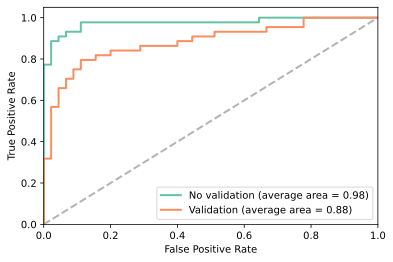

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

pal = sns.color_palette('Set2')


plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color=pal[-1], lw=lw, linestyle='--')


y_true = res_no_val.y_true
y_pred = res_no_val.y_pred
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, color=pal[0],
         lw=lw, label='No validation (average area = %0.2f)' % auc)


y_true = res_val.y_true
y_pred = res_val.y_pred
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, color=pal[1],
         lw=lw, label='Validation (average area = %0.2f)' % auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

    
plt.legend(loc="lower right")

In [20]:
dir_2 = '30s_1_30_60'
df_2 = pipeline.features.get_merged_df(join(base_path, dir_2), feature_methods)

In [21]:
res_2 = pipeline.models.kfold(df_2[features_val].fillna(0).values, df_2['target'], model)

In [24]:
res_2.roc_auc

0.8686868686868687